# I. Sentiment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
from IPython.display import display, HTML

data_home = 'C:/Users/user/Desktop/24Spring_ETA_Project/Dataset'
data_prefix = 'Star Wars- Episode '
output_dir = 'C:/Users/user/Desktop/24Spring_ETA_Project/Output'
path_prefix = 'starwars-combo'

OHCO = ['movie_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
SENTS = OHCO[:4]
PARAS = OHCO[:3]
CHAPS = OHCO[:2]
MOVIES = OHCO[:1]

BAG = OHCO[1:5] #chapnum

In [2]:
CORPUS_og = pd.read_csv(f"{output_dir}/{path_prefix}-CORPUS.csv")
# these terms indicates scene changes, but seems to have importance on tfidf, dfidf and such, so I'm erasing them for better interpretations
terms_to_remove = ['int', 'ext', 'interior', 'exterior']
filtered_CORPUS = CORPUS_og[~CORPUS_og['term_str'].isin(terms_to_remove)]
TOKENS = filtered_CORPUS.set_index(OHCO).sort_index()

VOCAB = pd.read_csv(f"{output_dir}/{path_prefix}-VOCAB.csv").set_index('term_str').sort_index()
LIB = pd.read_csv(f"{output_dir}/{path_prefix}-LIB.csv").set_index('movie_id')[['year','episode','movie_title','reviews']].sort_index()
BOW_get = pd.read_csv(f"{output_dir}/{path_prefix}-BOW.csv")
BOW_get.rename(columns = {'Unnamed: 2':'term_str'}, inplace = True)
BOW = BOW_get.set_index(['movie_id','chap_num','term_str']).sort_index()

In [3]:
salex_csv = 'C:/Users/user/Desktop/24Spring_ETA_Project/Dataset/lexicons/salex_nrc.csv'
nrc_cols = "nrc_negative nrc_positive nrc_anger nrc_anticipation nrc_disgust nrc_fear nrc_joy nrc_sadness nrc_surprise nrc_trust".split()
# emo = 'polarity'
# emo = 'sentiment'
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()

In [4]:
BOW

n     tfidf
movie_id chap_num term_str               
1        1.0      a           6  0.157711
                  ahhh        1  0.268594
                  alarming    1  0.375736
                  all         2  0.169711
                  ambassador  1  0.268594
...                          ..       ...
6        135.0    village     1  0.745336
                  warm        1  0.641926
                  watch       1  0.403014
                  wild        1  0.654426
                  yoda        1  0.403014

[100495 rows x 2 columns]

In [5]:
LIB['ep_id'] = LIB.episode.str.split(' ').str[1]
LIB['title_short'] = LIB.ep_id + ': ' + LIB.movie_title.str[:25] + '(' + LIB.year.astype(str) + ')'
LIB

year      episode              movie_title  reviews ep_id  \
movie_id                                                              
1         1999    Episode I       The Phantom Menace       52     I   
2         2002   Episode II     Attack of the Clones       65    II   
3         2005  Episode III      Revenge of the Sith       79   III   
4         1977   Episode IV               A New Hope       93    IV   
5         1980    Episode V  The Empire Strikes Back       95     V   
6         1983   Episode VI       Return of the Jedi       83    VI   

                               title_short  
movie_id                                    
1              I: The Phantom Menace(1999)  
2           II: Attack of the Clones(2002)  
3           III: Revenge of the Sith(2005)  
4                     IV: A New Hope(1977)  
5         V: The Empire Strikes Back(1980)  
6             VI: Return of the Jedi(1983)

In [6]:
SALEX = pd.read_csv(salex_csv).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]

In [7]:
SALEX

anger  anticipation  disgust  fear  joy  negative  positive  \
term_str                                                                   
abandon          0             0        0     1    0         1         0   
abandoned        1             0        0     1    0         1         0   
abandonment      1             0        0     1    0         1         0   
abduction        0             0        0     1    0         1         0   
aberration       0             0        1     0    0         1         0   
...            ...           ...      ...   ...  ...       ...       ...   
young            0             1        0     0    1         0         1   
youth            1             1        0     1    1         0         1   
zeal             0             1        0     0    1         0         1   
zealous          0             0        0     0    1         0         1   
zest             0             1        0     0    1         0         1   

             sadness  surprise  trust  sentiment  
term_str                                          
abandon            1         0      0         -1  
abandoned          1         0      0         -1  
abandonment        1         1      0         -1  
abduction          1         1      0         -1  
aberration         0         0      0         -1  
...              ...       ...    ...        ...  
young              0         1      0          1  
youth              0         1      0          1  
zeal               0         1      1          1  
zealous            0         0      1          1  
zest               0         0      1          1  

[3688 rows x 11 columns]

## Sentiment VOCAB_SENT
Combine SALEX with VOCAB

In [8]:
V = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)

In [9]:
V.head(10)

n         p          i  n_chars  n_tokens max_pos_group max_pos  \
term_str                                                                        
abandon       3  0.000017  15.818374        7         1            NN      NN   
abandoned     1  0.000006  17.403337        9         1            VB     VBN   
absence       1  0.000006  17.403337        7         1            NN      NN   
abyss         9  0.000052  14.233412        5         1            NN      NN   
accident      2  0.000012  16.403337        8         1            NN      NN   
accomplish    4  0.000023  15.403337       10         1            NN      NN   
accomplished  1  0.000006  17.403337       12         1            VB     VBN   
accord        1  0.000006  17.403337        6         1            NN      NN   
accurate      2  0.000012  16.403337        8         1            NN      NN   
achieve       1  0.000006  17.403337        7         1            NN      NN   

              stop stem_porter stem_snowball  ... anticipation  disgust  fear  \
term_str                                      ...                               
abandon          0     abandon       abandon  ...            0        0     1   
abandoned        0     abandon       abandon  ...            0        0     1   
absence          0      absenc        absenc  ...            0        0     1   
abyss            0       abyss         abyss  ...            0        0     1   
accident         0       accid         accid  ...            0        0     1   
accomplish       0  accomplish    accomplish  ...            0        0     0   
accomplished     0  accomplish    accomplish  ...            0        0     0   
accord           0      accord        accord  ...            0        0     0   
accurate         0       accur         accur  ...            0        0     0   
achieve          0      achiev        achiev  ...            0        0     0   

              joy  negative  positive  sadness  surprise  trust  sentiment  
term_str                                                                    
abandon         0         1         0        1         0      0         -1  
abandoned       0         1         0        1         0      0         -1  
absence         0         1         0        1         0      0         -1  
abyss           0         1         0        1         0      0         -1  
accident        0         1         0        1         1      0         -1  
accomplish      1         0         1        0         0      0          1  
accomplished    1         0         1        0         0      0          1  
accord          0         0         1        0         0      1          1  
accurate        0         0         1        0         0      1          1  
achieve         1         0         1        0         0      1          1  

[10 rows x 32 columns]

## Sentiment BOW_SENT
Merge VOCAB with BOW

In [10]:
B = BOW.join(V[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()
B.head(10)

n     tfidf max_pos  anger  anticipation  \
movie_id chap_num term_str                                               
1        1.0      alarming    1  0.375736     VBG    0.0           0.0   
                  ambassador  1  0.268594      NN    0.0           0.0   
                  beautiful   1  0.214181      NN    0.0           0.0   
                  black       1  0.198801      JJ    0.0           0.0   
                  blockade    2  0.432942      NN    1.0           0.0   
                  conflict    1  0.275474      NN    1.0           0.0   
                  congress    1  0.304308      NN    0.0           0.0   
                  deadly      1  0.214181      RB    1.0           0.0   
                  dispute     1  0.292810      NN    1.0           0.0   
                  greedy      1  0.340022      NN    0.0           0.0   

                              disgust  fear  joy  sadness  surprise  trust  \
movie_id chap_num term_str                                                   
1        1.0      alarming        0.0   1.0  0.0      0.0       1.0    0.0   
                  ambassador      0.0   0.0  0.0      0.0       0.0    1.0   
                  beautiful       0.0   0.0  1.0      0.0       0.0    0.0   
                  black           0.0   0.0  0.0      1.0       0.0    0.0   
                  blockade        0.0   1.0  0.0      1.0       0.0    0.0   
                  conflict        0.0   1.0  0.0      1.0       0.0    0.0   
                  congress        1.0   0.0  0.0      0.0       0.0    1.0   
                  deadly          1.0   1.0  0.0      1.0       0.0    0.0   
                  dispute         0.0   0.0  0.0      0.0       0.0    0.0   
                  greedy          1.0   0.0  0.0      0.0       0.0    0.0   

                              sentiment  
movie_id chap_num term_str               
1        1.0      alarming         -1.0  
                  ambassador        1.0  
                  beautiful         1.0  
                  black            -1.0  
                  blockade         -1.0  
                  conflict         -1.0  
                  congress          0.0  
                  deadly           -1.0  
                  dispute          -1.0  
                  greedy           -1.0

### Weight Emotions by TFIDF

In [11]:
for col in emo_cols:
    B[col] = B[col] * B.tfidf

In [12]:
B.head()

n     tfidf max_pos     anger  anticipation  \
movie_id chap_num term_str                                                  
1        1.0      alarming    1  0.375736     VBG  0.000000           0.0   
                  ambassador  1  0.268594      NN  0.000000           0.0   
                  beautiful   1  0.214181      NN  0.000000           0.0   
                  black       1  0.198801      JJ  0.000000           0.0   
                  blockade    2  0.432942      NN  0.432942           0.0   

                              disgust      fear       joy   sadness  surprise  \
movie_id chap_num term_str                                                      
1        1.0      alarming        0.0  0.375736  0.000000  0.000000  0.375736   
                  ambassador      0.0  0.000000  0.000000  0.000000  0.000000   
                  beautiful       0.0  0.000000  0.214181  0.000000  0.000000   
                  black           0.0  0.000000  0.000000  0.198801  0.000000   
                  blockade        0.0  0.432942  0.000000  0.432942  0.000000   

                                 trust  sentiment  
movie_id chap_num term_str                         
1        1.0      alarming    0.000000  -0.375736  
                  ambassador  0.268594   0.268594  
                  beautiful   0.000000   0.214181  
                  black       0.000000  -0.198801  
                  blockade    0.000000  -0.432942

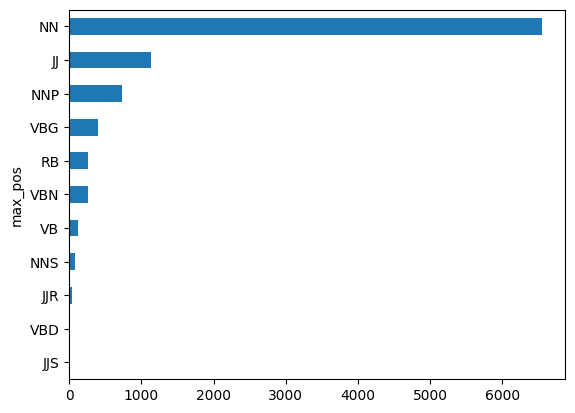

In [13]:
B.max_pos.value_counts().sort_values().plot.barh();

## Sentiment DOC_SENT

In [14]:
EMO_MOVIES = B.groupby(['movie_id'])[emo_cols].mean()
EMO_CHAPS = B.groupby(['movie_id','chap_num'])[emo_cols].mean()

In [15]:
EMO_CHAPS.head(5)

anger  anticipation   disgust      fear       joy  \
movie_id chap_num                                                         
1        1.0       0.085980      0.057278  0.043350  0.103621  0.065190   
         3.0       0.000000      0.211103  0.000000  0.211103  0.000000   
         4.0       0.085796      0.161780  0.132799  0.211406  0.147737   
         5.0       0.264402      0.000000  0.271845  0.687782  0.000000   
         6.0       1.151035      0.373019  0.430663  1.329138  0.568348   

                    sadness  surprise     trust  sentiment  
movie_id chap_num                                           
1        1.0       0.057582  0.014451  0.130420  -0.008653  
         3.0       0.000000  0.000000  0.462290   0.462290  
         4.0       0.250837  0.111149  0.167305  -0.149125  
         5.0       0.000000  0.423380  0.271845  -0.687782  
         6.0       0.430663  0.000000  0.568348  -1.817032

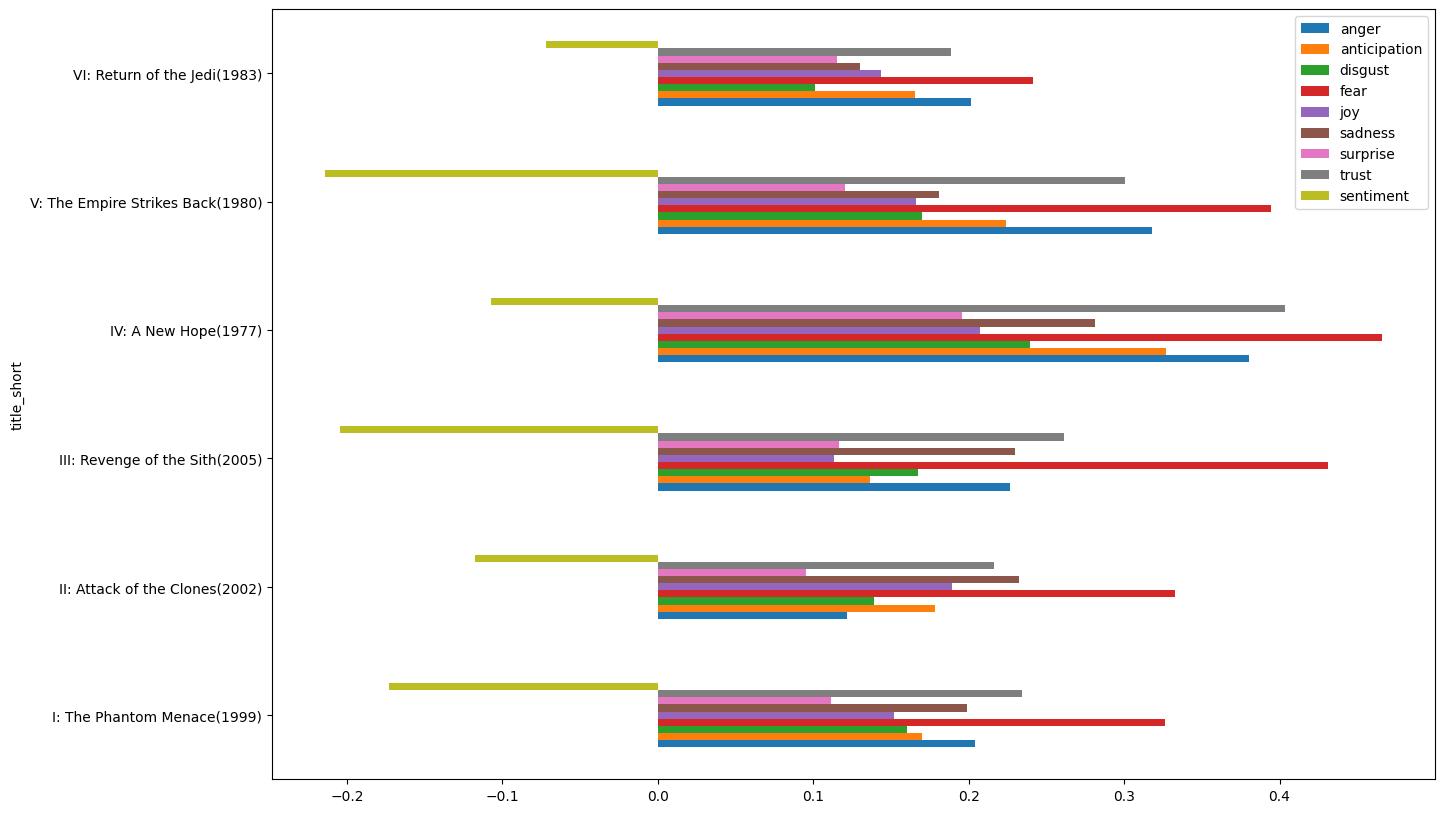

In [16]:
EMO_MOVIES.index = LIB.title_short #book_title
EMO_MOVIES.plot.barh(figsize=(15,10));

### Compare 1-3 movies vs 4-6 movies

In [17]:
movie_1 = LIB['title_short'][1]
movie_2 = LIB['title_short'][2]
movie_3 = LIB['title_short'][3]
movie_4 = LIB['title_short'][4]
movie_5 = LIB['title_short'][5]
movie_6 = LIB['title_short'][6]

In [18]:
EP1_3 = EMO_MOVIES.loc[movie_1:movie_3].copy()
EP4_6 = EMO_MOVIES.loc[movie_4:movie_6].copy()

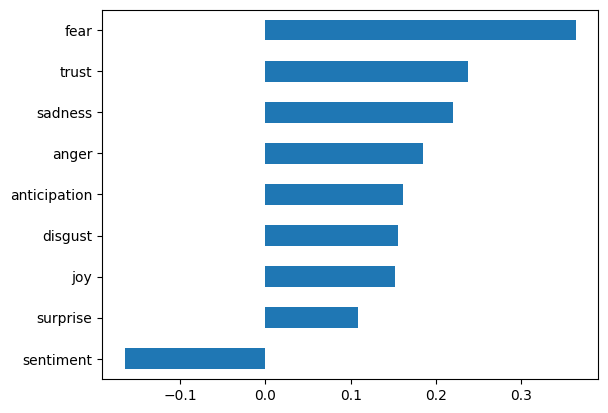

In [19]:
EP1_3.mean().sort_values().plot.barh();

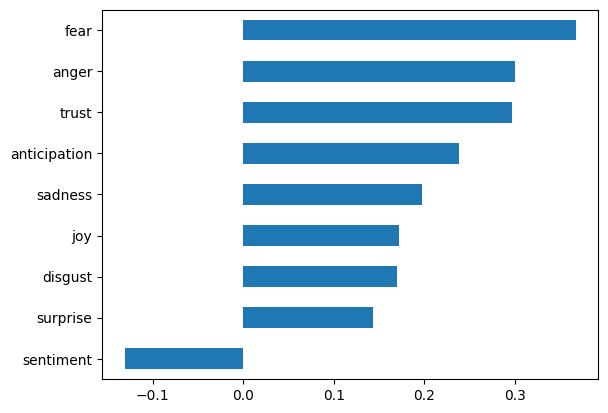

In [20]:
EP4_6.mean().sort_values().plot.barh();

### Compare texts

In [21]:
EP1 = EMO_CHAPS.loc[1].copy()
EP2 = EMO_CHAPS.loc[2].copy()
EP3 = EMO_CHAPS.loc[3].copy()
EP4 = EMO_CHAPS.loc[4].copy()
EP5 = EMO_CHAPS.loc[5].copy()
EP6 = EMO_CHAPS.loc[6].copy()

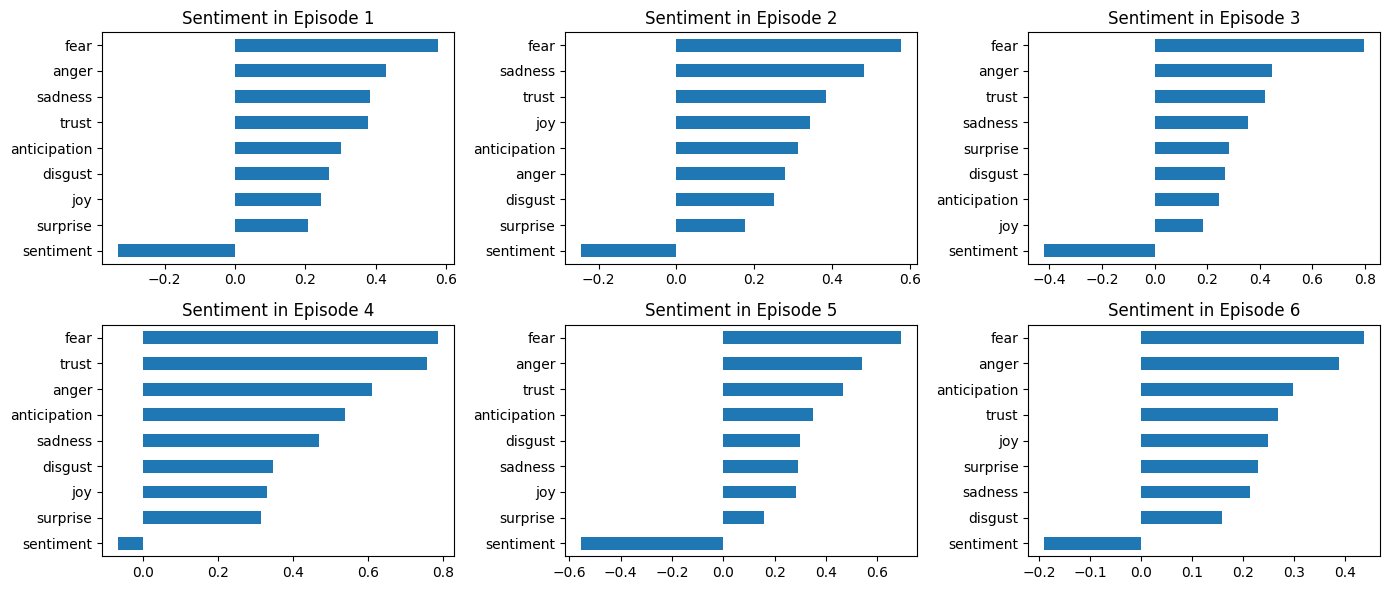

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(14, 6))
axs = axs.flatten()

episodes = [EP1, EP2, EP3, EP4, EP5, EP6]

for i, episode in enumerate(episodes):
    episode.mean().sort_values().plot.barh(ax=axs[i])
    axs[i].set_title(f'Sentiment in Episode {i + 1}')

plt.tight_layout()
plt.show()

## Sentiment Plot
1. Barplot\
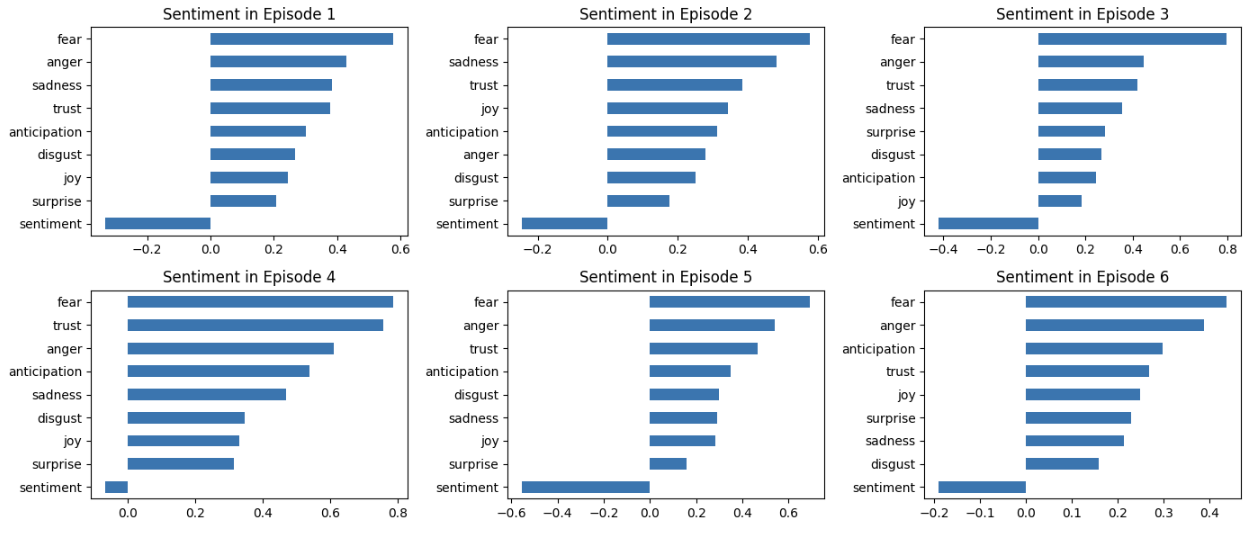\
2. Line graph\
Episode 1:\
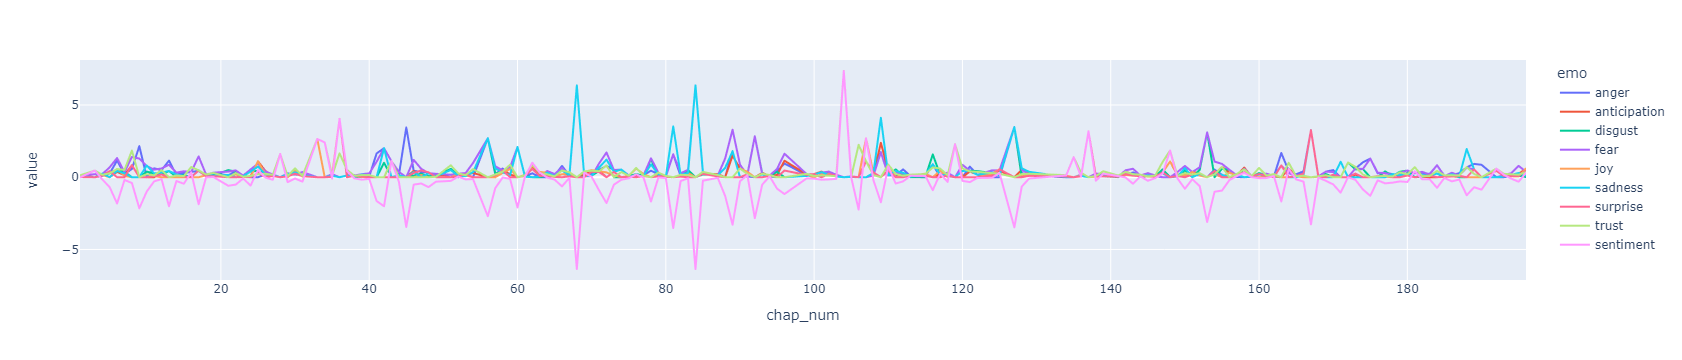\
Episode 2:\
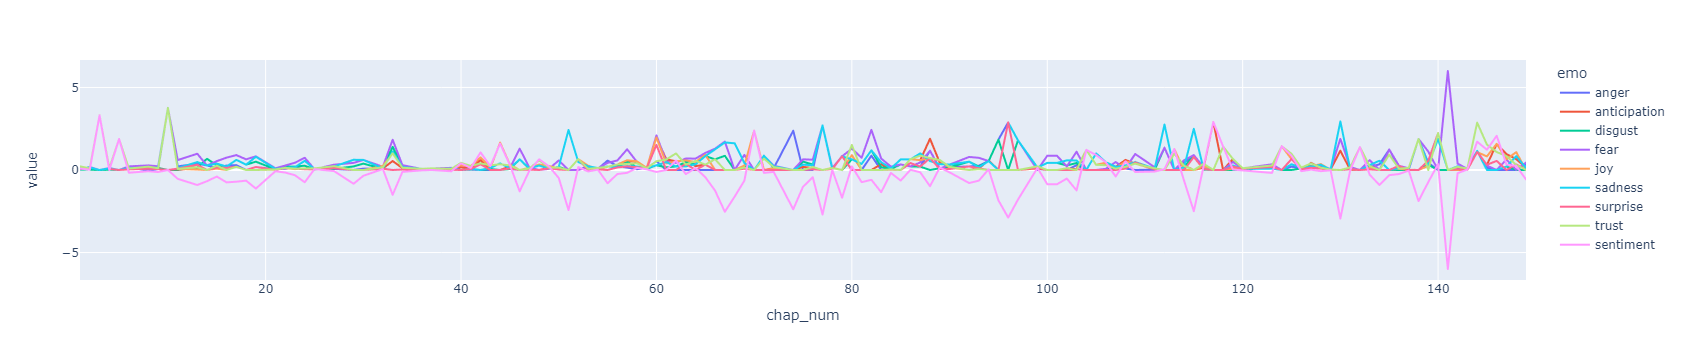\
Episode 3:\
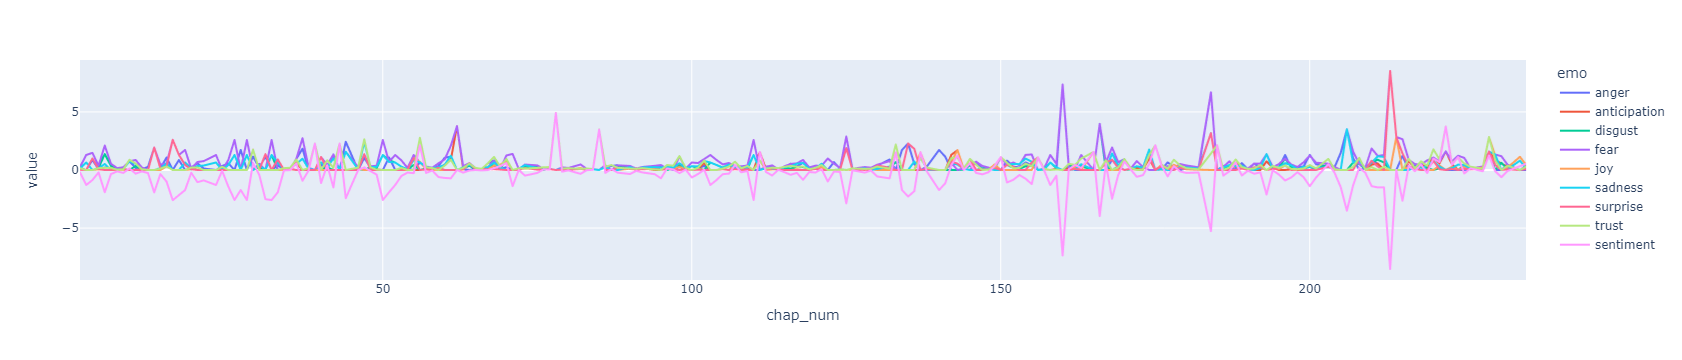\
Episode 4:\
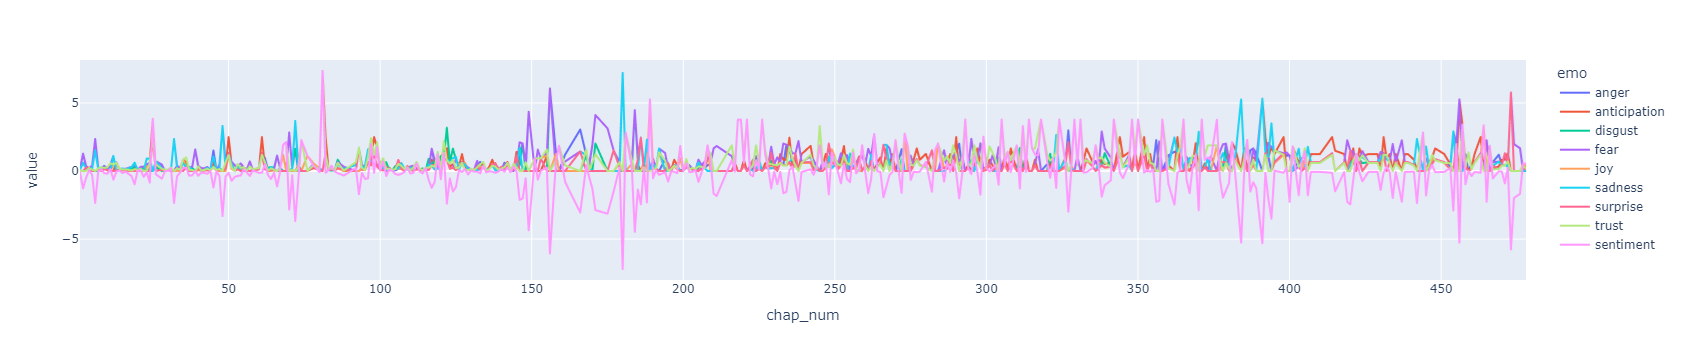\
Episode 5:\
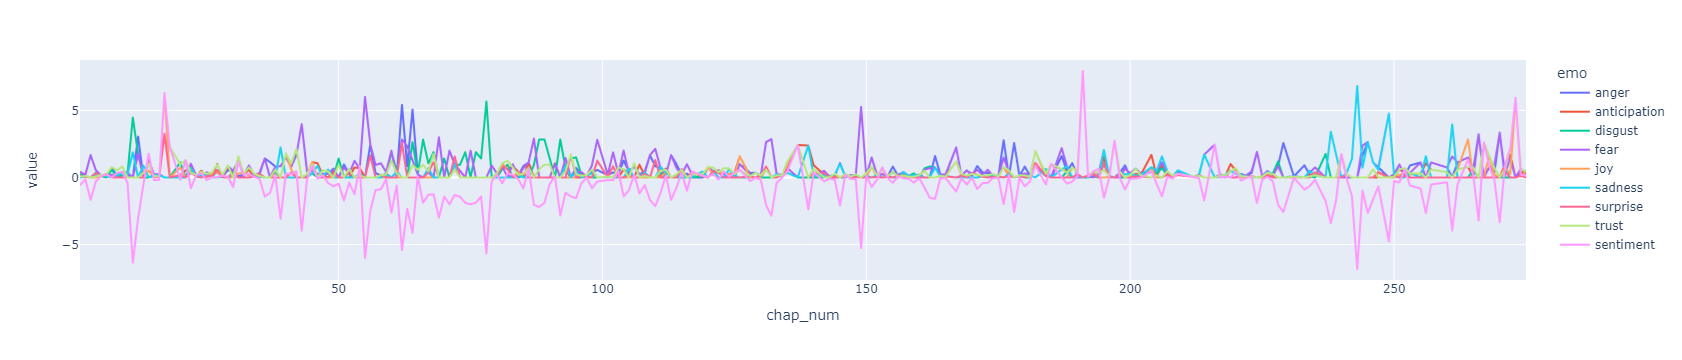\
Episode 6:\
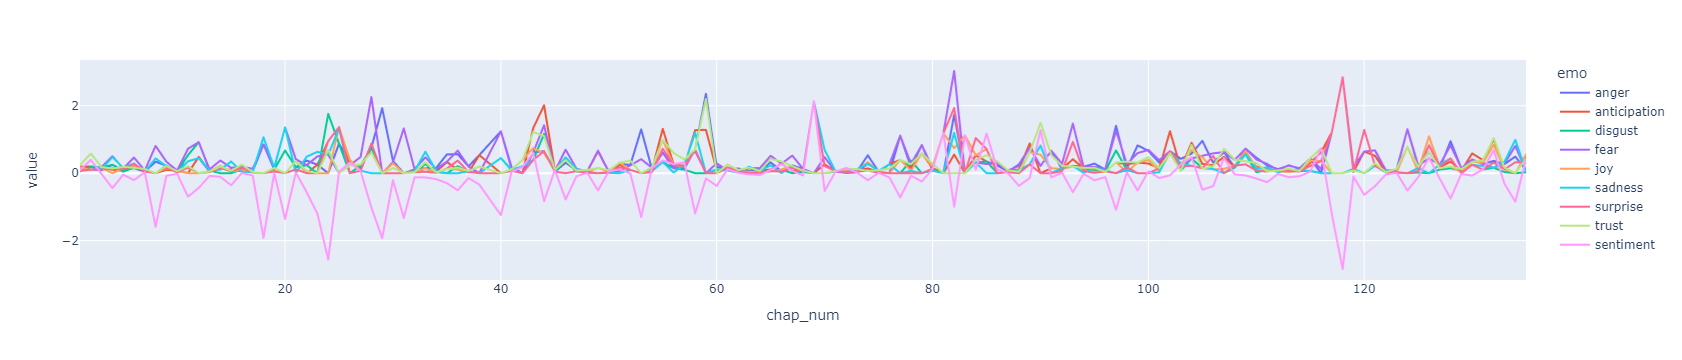\

In [23]:
EP1_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("movie_id == {}".format(1))
EP2_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("movie_id == {}".format(2))
EP3_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("movie_id == {}".format(3))
EP4_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("movie_id == {}".format(4))
EP5_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("movie_id == {}".format(5))
EP6_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("movie_id == {}".format(6))

## Other Visualization

In [24]:
def plot_sentiments(df, emo='sentiment'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

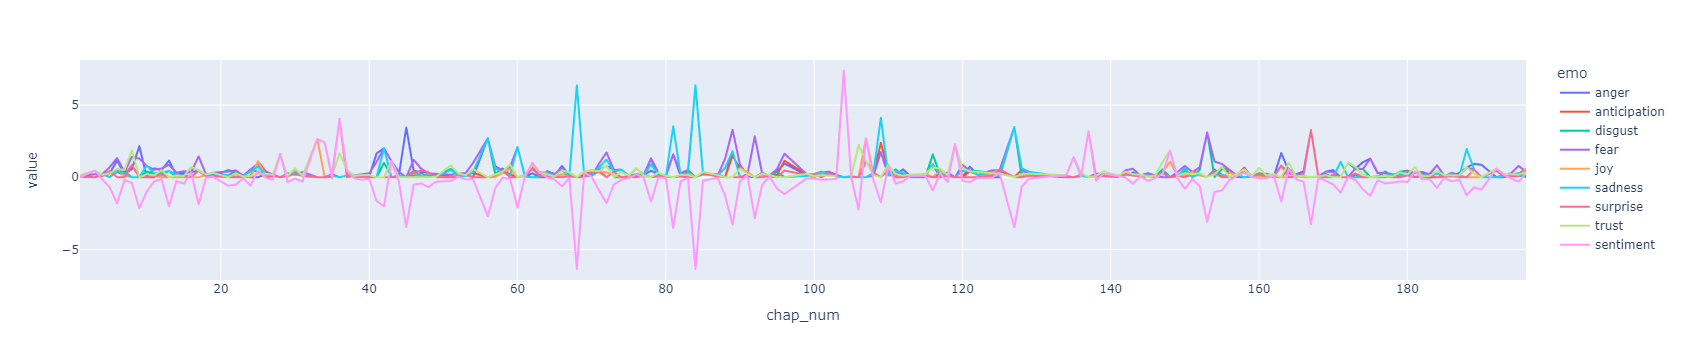

In [25]:
px.line(EP1_chaps_thin, x='chap_num', y='value', color='emo')

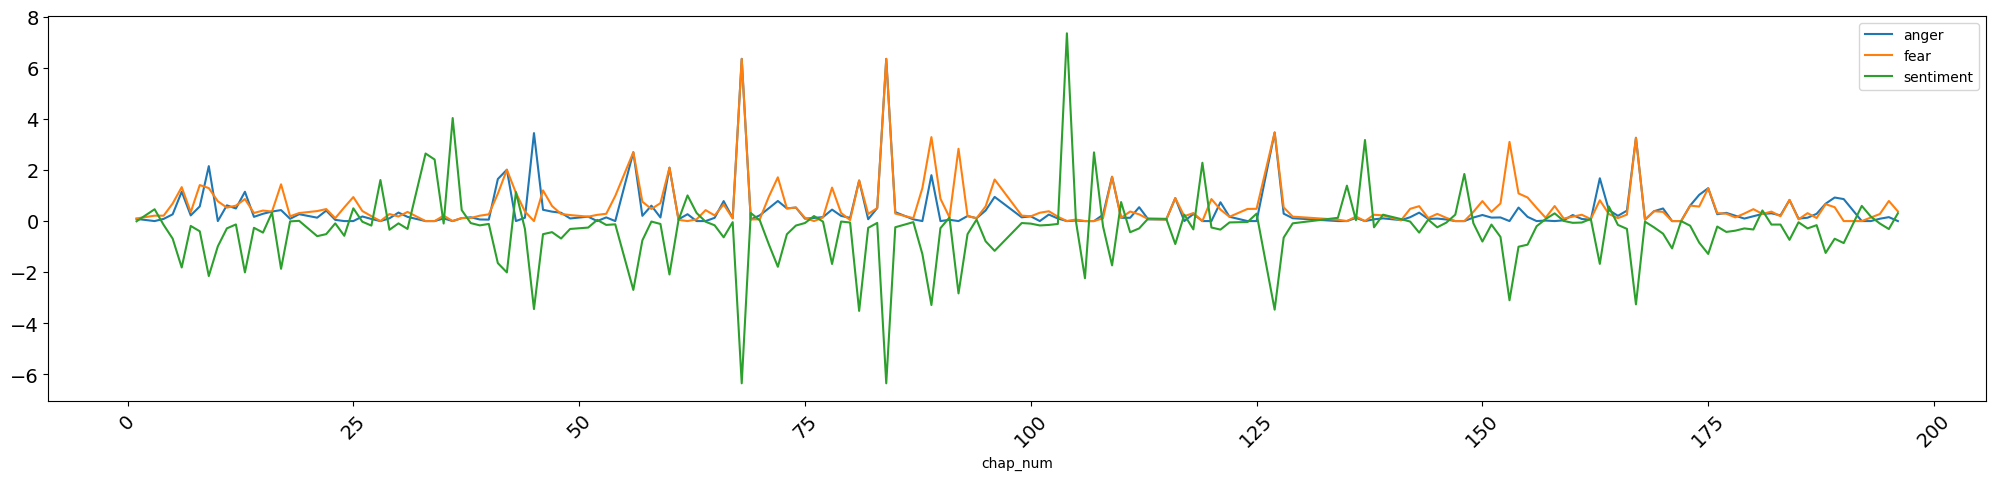

In [26]:
plot_sentiments(EP1, ['anger','fear','sentiment'])

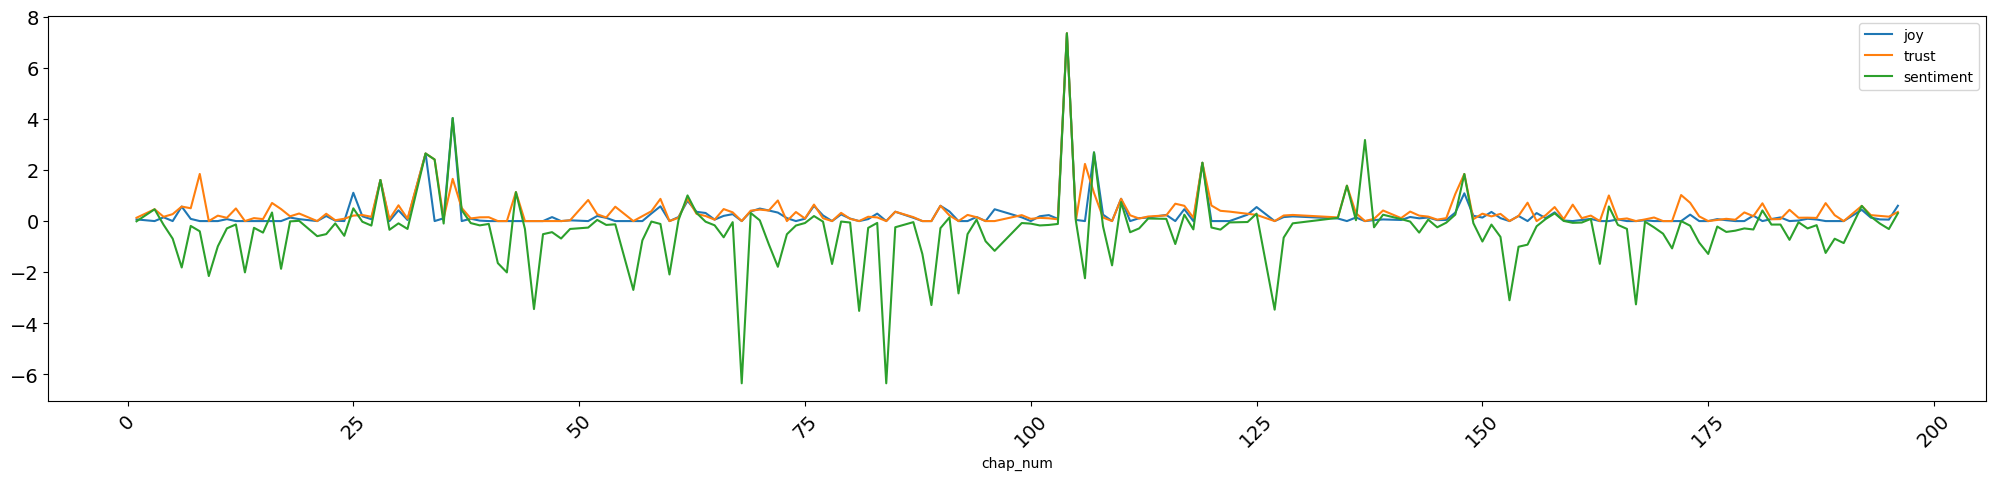

In [27]:
plot_sentiments(EP1, ['joy','trust','sentiment'])

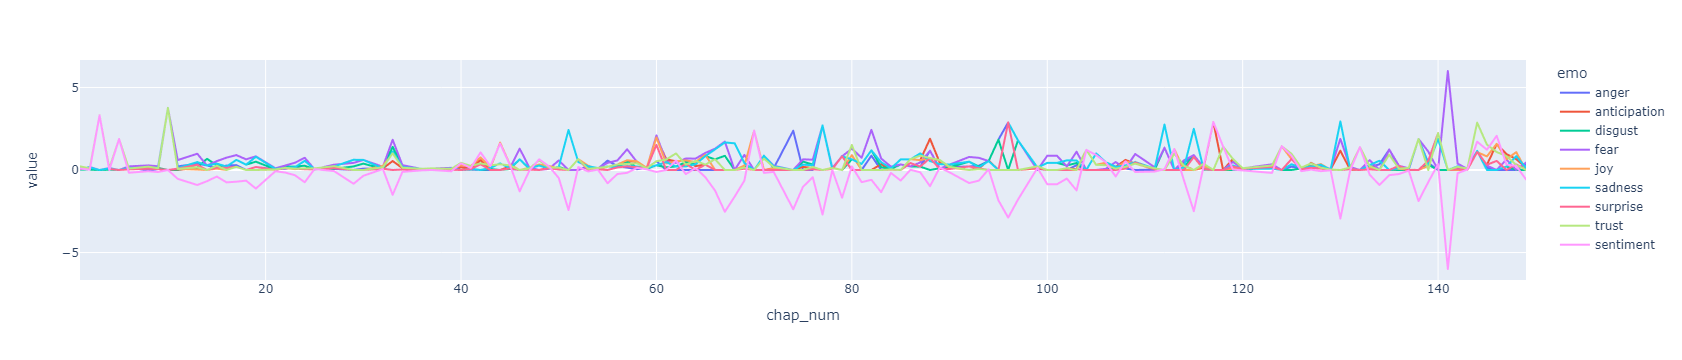

In [28]:
px.line(EP2_chaps_thin, x='chap_num', y='value', color='emo')

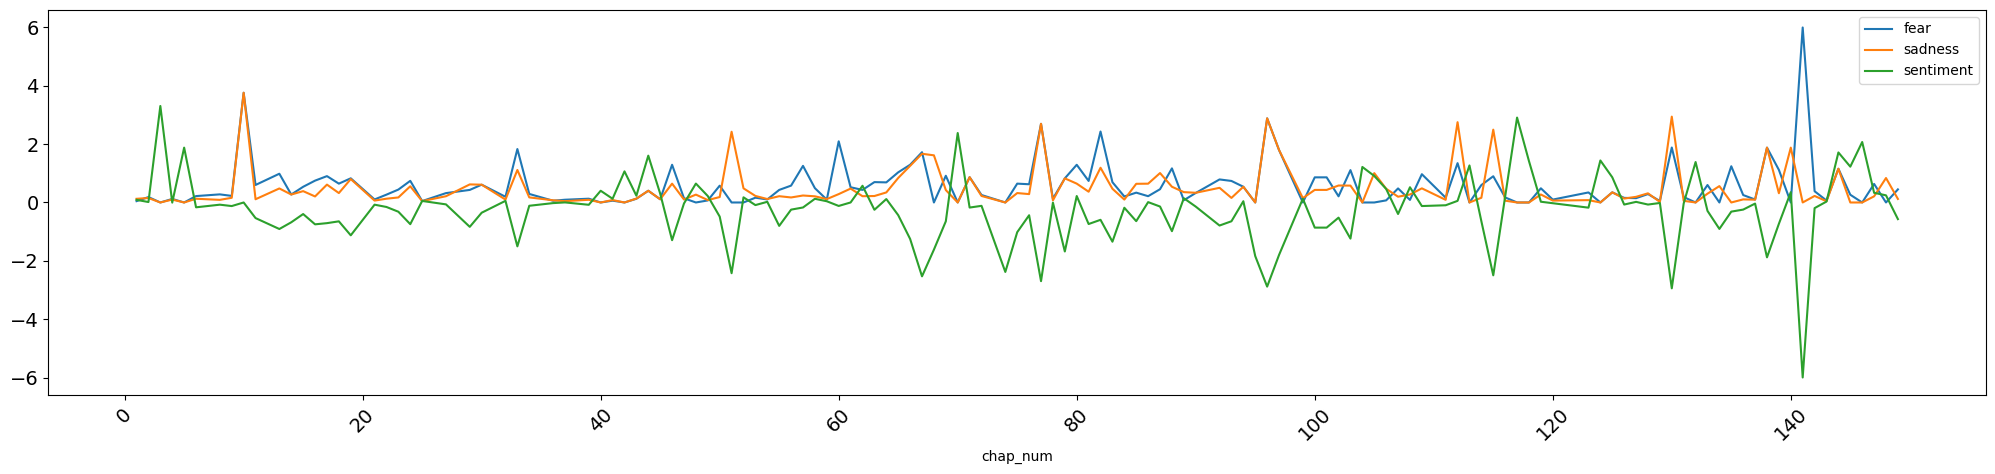

In [29]:
plot_sentiments(EP2, ['fear','sadness','sentiment'])

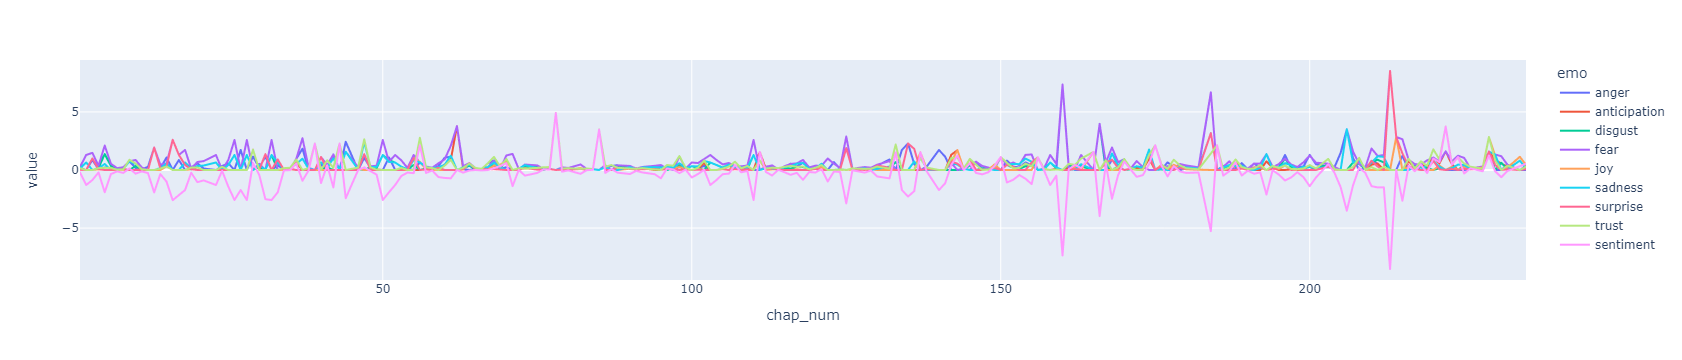

In [39]:
px.line(EP3_chaps_thin, x='chap_num', y='value', color='emo')

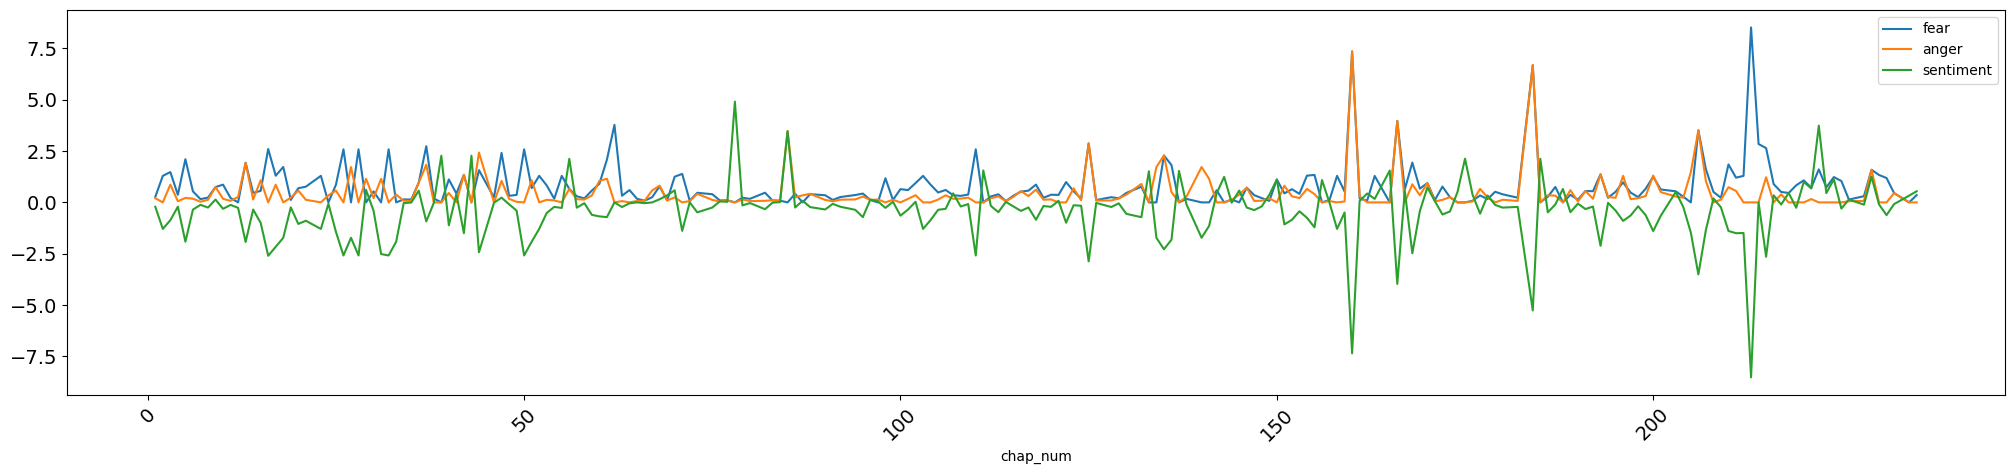

In [31]:
plot_sentiments(EP3, ['fear','anger','sentiment'])

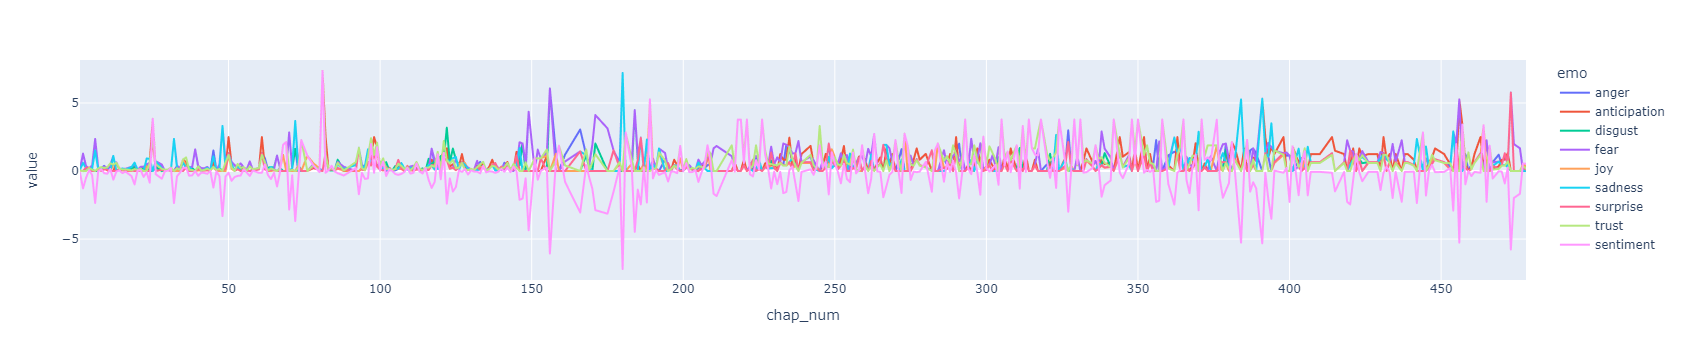

In [40]:
px.line(EP4_chaps_thin, x='chap_num', y='value', color='emo')

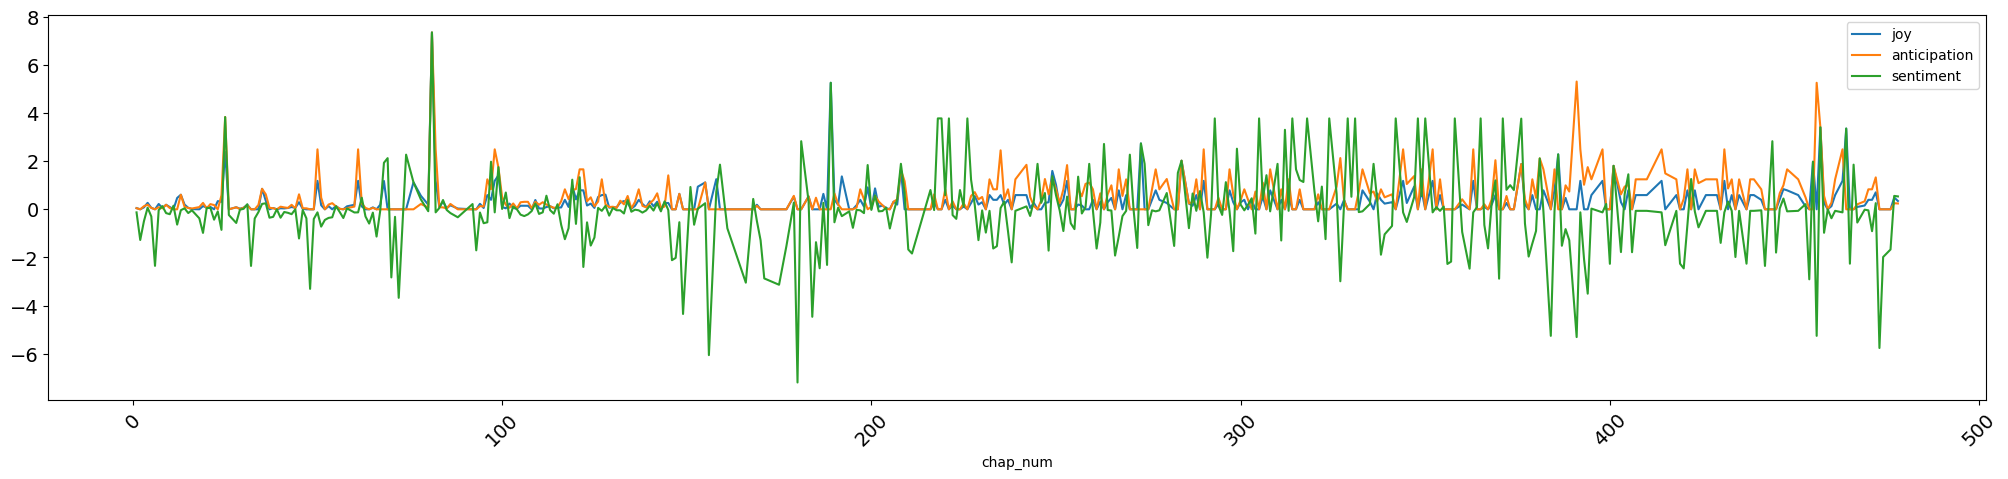

In [33]:
plot_sentiments(EP4, ['joy','anticipation','sentiment'])

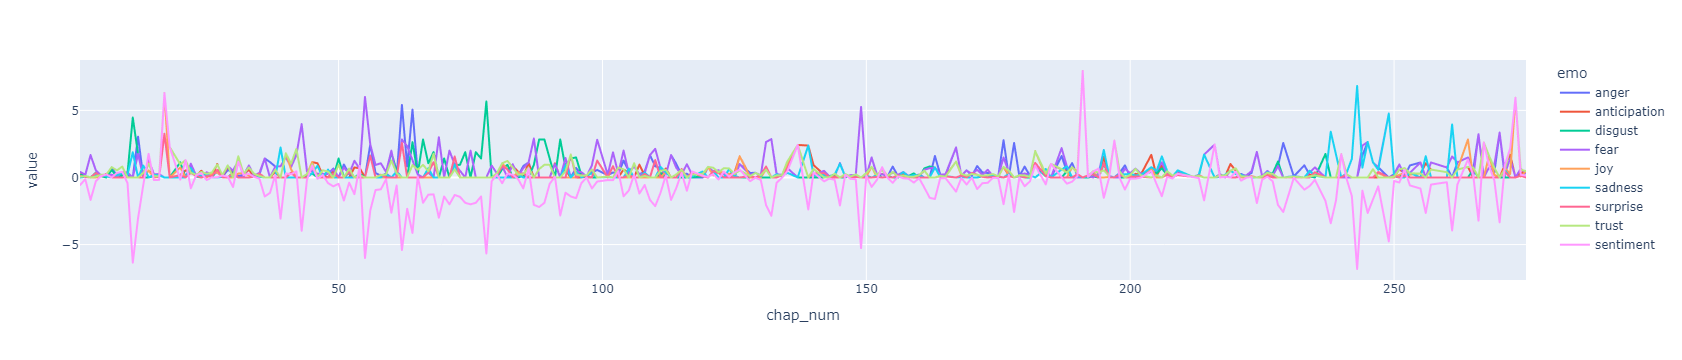

In [41]:
px.line(EP5_chaps_thin, x='chap_num', y='value', color='emo')

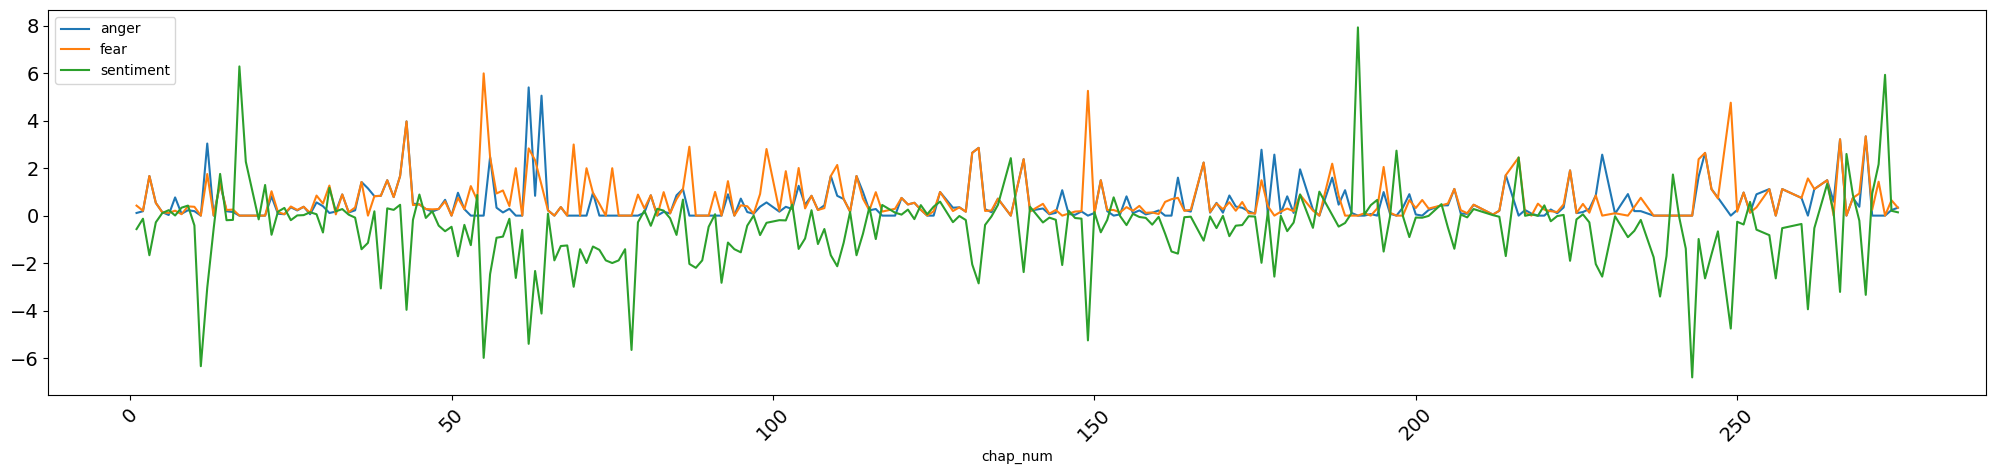

In [35]:
plot_sentiments(EP5, ['anger','fear','sentiment'])

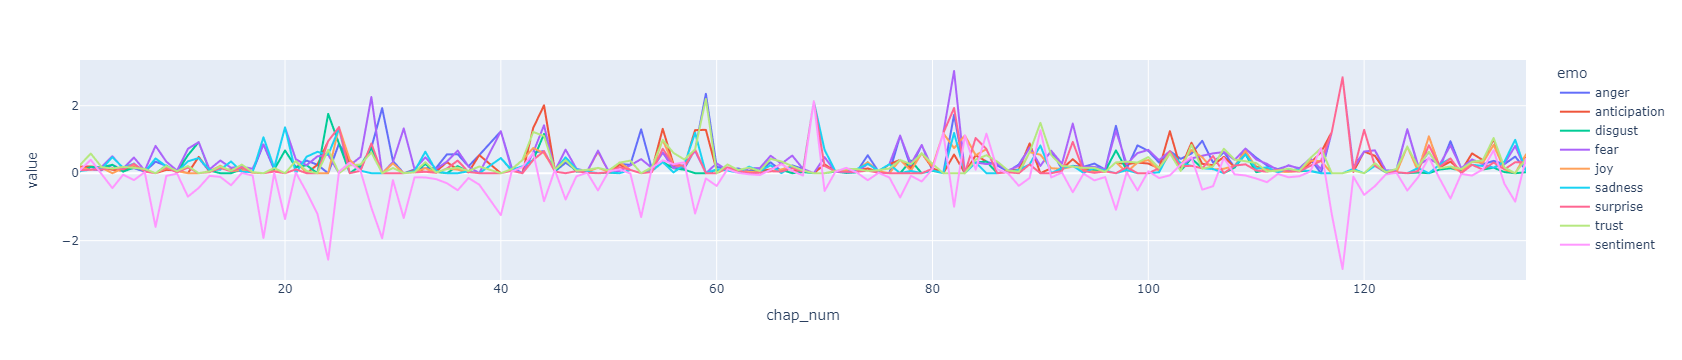

In [42]:
px.line(EP6_chaps_thin, x='chap_num', y='value', color='emo')

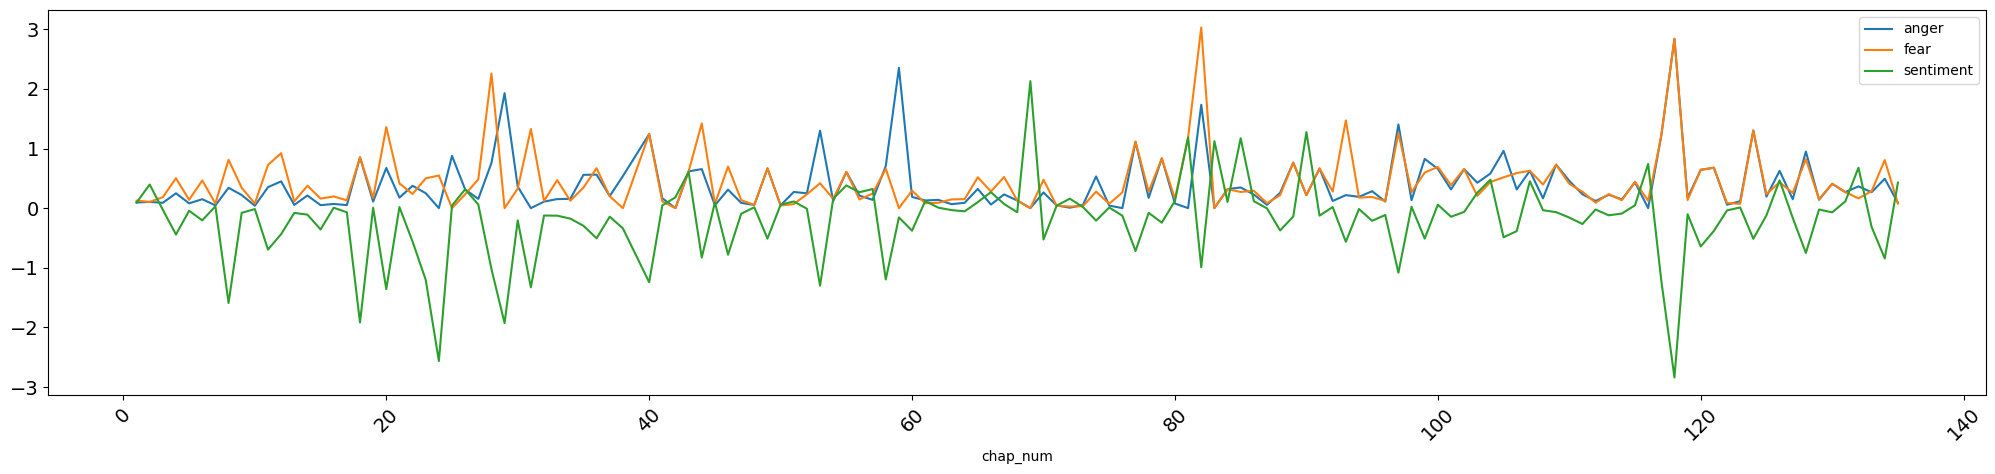

In [37]:
plot_sentiments(EP6, ['anger','fear','sentiment'])

# Save

In [38]:
V.to_csv(f"{output_dir}/{path_prefix}-VOCAB_SENT.csv", index=True)
B.to_csv(f"{output_dir}/{path_prefix}-BOW_SENT.csv", index=True)
EMO_CHAPS.to_csv(f"{output_dir}/{path_prefix}-DOC_SENT.csv", index=True)